# Market Areas Indicators creations using Raster Data

## Create market areas

### How does it work?

Considering the initial reference point (the centroid) of the market, a market with a radius `r` is generated, which is represented within a square, taking into account the width of the `grid` (in km) that you want to calculate.


In [59]:
import requests, pandas as pd, alphashape
from tqdm import tqdm
import geopandas as gpd, numpy as np
from shapely.geometry import LineString, Point
from shapely.geometry import Polygon
import geopy.distance
import warnings 
import pandas as pd, numpy as np
import geopandas as gpd, rasterio as rio
from rasterio.mask import mask


warnings.filterwarnings('ignore')

ecl_dist = geopy.distance.geodesic

crs_moll='EPSG:3857'
crs_lat='EPSG:4326'

For example, if we slightly modify the code from [`make_grid`](https://github.com/alexanderquispe/osrm_python/blob/main/osrmareas/areas.py)

In [60]:
import matplotlib.pyplot as plt


def destination(x, y, size_grid):
    coords_pol = [
        (x, y),
        (x + size_grid, y),
        (x + size_grid, y + size_grid),
        (x, y + size_grid),
    ]
    center = size_grid / 2
    coords_center = [x + center, y + center]
    return coords_center

from_ =[24.933989, 67.107785]
def generate_grid(center_lat_long = from_ , radius_km=5, grid_km_size=2.5):

    n_grid = radius_km / grid_km_size * 2

    center = list(reversed(center_lat_long))
    radius_km = radius_km * 1000
    initial_center = Point(center)

    point_c = gpd.GeoSeries(initial_center, crs=crs_lat).to_crs(crs_moll)
    point_center = point_c.buffer(radius_km, cap_style=3)

    minX, minY, maxX, maxY = point_center.total_bounds
    size_grid_km = (maxY - minY) / n_grid
    cols_grid = list(np.arange(minX, maxX, size_grid_km))
    rows_grid = list(np.arange(minY, maxY, size_grid_km))

    x_destinations = []
    y_destinations = []

    plt.figure(figsize=(6, 6))

    for x in cols_grid:
        for y in rows_grid:
            final = destination(x, y, size_grid_km)
            x_destinations.append(final[0])
            y_destinations.append(final[1])

    ax = plt.gca()
    point_c_moll = point_c.bounds[["minx", "miny"]].T.values

    for i in range(len(cols_grid)):
        plt.axhline(y=rows_grid[i])
        plt.axvline(x=cols_grid[i])

    plt.scatter(point_c_moll[0][0], point_c_moll[1][0], color="red", s=200)

    plt.scatter(x_destinations, y_destinations)
    plt.axis("off")

    ax.set_xlim((minX, maxX))
    ax.set_ylim((minY, maxY))
    plt.show()

    print(len(y_destinations))

In the provided code snippets, the function `generate_grid` is called with different parameters to create grids for different market scenarios. Let's elaborate on each scenario:

- For a market with a radius of 5km and a grid size of 2.5km:


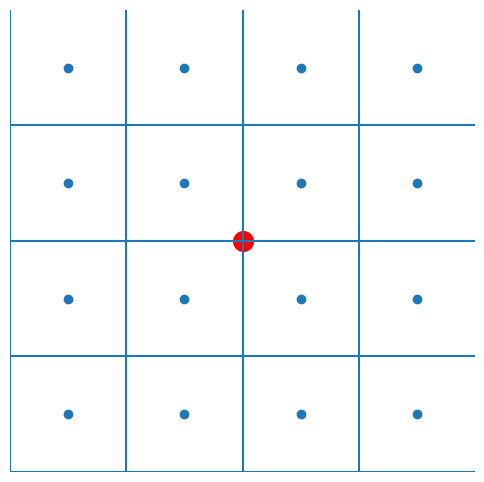

16


In [61]:
generate_grid(radius_km=5, grid_km_size=2.5)

This function call generates a grid where each grid cell covers an area of 2.5km x 2.5km within the 5km radius of the market. With this configuration, there would be 16 final destination points.

- For a market with a radius of 5km and a grid size of 1km:

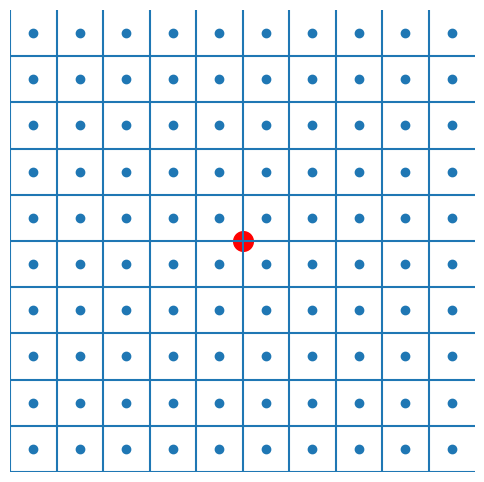

100


In [62]:
generate_grid(radius_km=5, grid_km_size=1)

In this scenario, each grid cell covers an area of 1km x 1km within the 5km radius. Consequently, there would be 100 final destination points.

- For a grid cell size of 100 meters and a market radius of 1km:

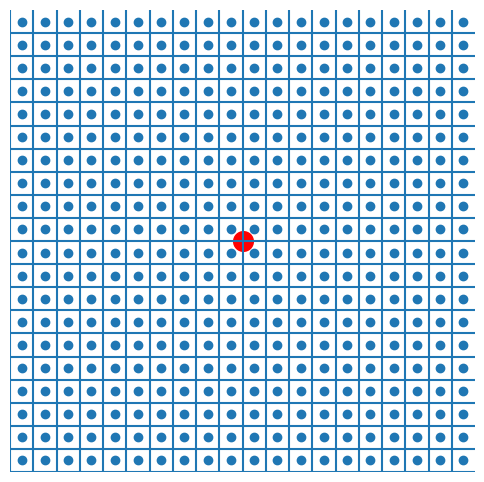

400


In [63]:
generate_grid(radius_km=1, grid_km_size=0.1)

This call results in a grid where each grid cell covers an area of 100m x 100m within a 1km radius. Hence, there would be 400 final destination points.

These function calls demonstrate how adjusting the grid size affects the granularity of the grid and consequently the number of final destination points within a given market radius.

The provided code utilizes the OSRM Directions API through the `osrm_python` package to perform route calculations and visualize them. Let's break down the code and its functionalities:

### Setting Up OSRM Directions API with [`osrm_python`](https://github.com/alexanderquispe/osrm_python/tree/main?tab=readme-ov-file#osrm-routes) package

To use the library, you need to have the OSRM server running. For this specific case, a PBF file of Pakistan is used.

In [64]:
# Download PBF file
from osrmareas.downloader import GetPBF
download = GetPBF()
download.country(['pakistan']).get(save_dir='countr_pk')

pbf_file = 'pakistan-latest.osm' #{country, subregion}-latest.osm
pbf_file_path = './countr_pk'

from osrmareas.osrm import Server
pk_server = Server(pbf_file, pbf_file_path)

Convert the country names to lowercase and replace spaces with dashes (-).
source: https://download.geofabrik.de/


### Generating OSRM Files and Running the Server

The following code generates the necessary files for OSRM and starts the local server.

In [65]:
# Generate the files
pk_server.gen_osrm_1()
pk_server.prepare_server_2()

# Run the server locally
pk_server.run_server()

Please run the following function only once for each .pbf file. (It takes some time to execute, and consume all the CPU)
Found ./countr_pk\pakistan-latest.osrm file
Done, generate a osrm file
Please run the following function only once for each .pbf file. (It takes some time to execute, and consume all the CPU)
Done, I have generated the local OSRM server with `{server}.run_server()`.
The server is running in the background, you can start making queries.


### Calculating Routes and Visualizing

The code snippet below calculates a route from a starting point (`from_`) to an ending point (`to_`) and plots it on a map.

In [66]:
from osrmareas import areas
from_ = [28.421612, 70.313059]
to_ = [28.408835, 70.327077]
rt = areas.get_osrm_route(from_, to_)
rt

,geometry,dist_driving_km,dist_eucl_km,dest_lon,dest_lat,origin_lon,origin_lat
0,"LINESTRING (70.31306 28.42161, 70.31306 28.421...",2.7467,1.972733,28.408835,70.327077,28.421612,70.313059


<Axes: >

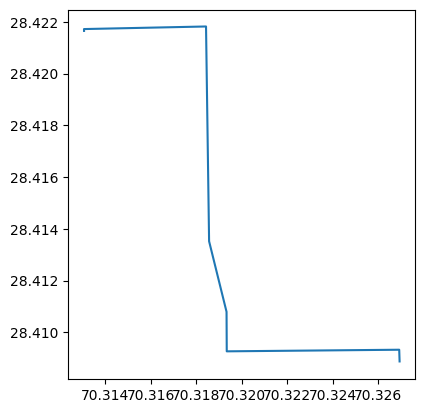

In [67]:
rt.plot()

### Illustrating Grid Routes

The subsequent code snippets demonstrate route calculations and visualizations for different grid configurations:

1. Radius of 5km and grid size of 2.5km:

100%|██████████| 16/16 [00:00<00:00, 97.50it/s] 


<Axes: >

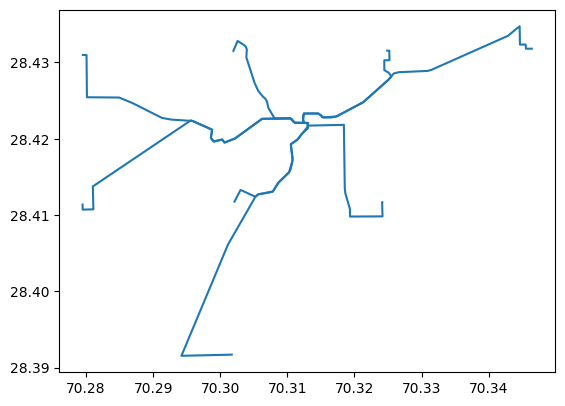

In [68]:
all_rt_1=areas.get_routes(from_, radius_km=5, grid_km_size= 2.5)
all_rt_1.plot()

2. Radius of 5km and grid size of 1km:

100%|██████████| 100/100 [00:00<00:00, 131.97it/s]


<Axes: >

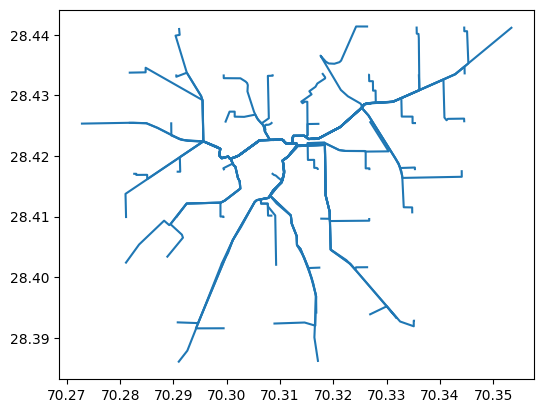

In [69]:
all_rt_2=areas.get_routes(from_, radius_km=5, grid_km_size= 1)
all_rt_2.plot()

3. Radius of 1km and grid size of 100 meters:

100%|██████████| 400/400 [00:02<00:00, 162.05it/s]


<Axes: >

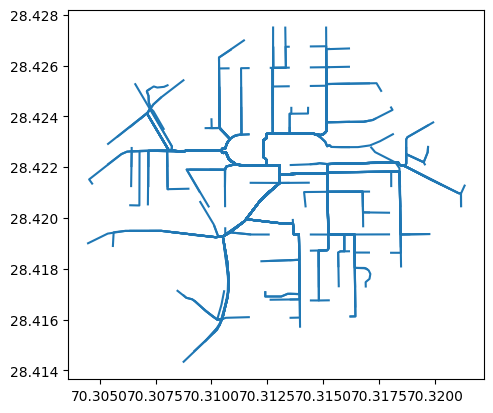

In [70]:
all_rt_3=areas.get_routes(from_, radius_km=1, grid_km_size= 0.1)
all_rt_3.plot()

### Extracting Routes within a Specific Distance

Lastly, the code snippet below extracts routes within a specified distance and generates a shapefile representing a market from the centroid of a specific radius.

100%|██████████| 1600/1600 [00:14<00:00, 112.14it/s]


<Axes: >

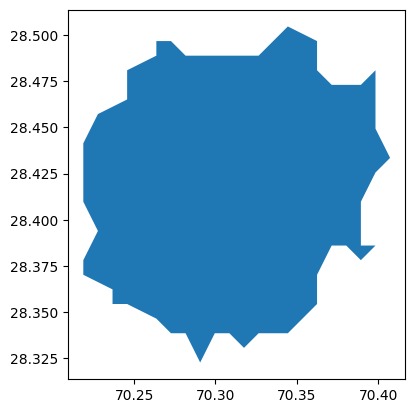

In [71]:
all_rt_3=areas.get_routes(from_, radius_km=20, grid_km_size= 1)
ameba = areas.get_ameba(all_rt_3, max_km = 12, alpha = 80, km_col='dist_driving_km')
ameba.plot()

This code snippet demonstrates the capabilities of the `osrm_python` package for route calculation and visualization, particularly useful for market analysis and planning.

### OSM vs Google Maps API

Let's first provide some context for our case. We have approximately 250 markets, each with a radius of about 10km, and the width of the final destination search grid is 100 meters. This means we have 4000 search destinations per market. So, in total, we would have 4000 destinations multiplied by 250 markets, resulting in 1,000,000 destinations.

When using the Google Maps API, we have several options to choose from. However, for this case, the required service to subscribe to would be the [SKU: Router: Compute Routes - Basic](https://developers.google.com/maps/documentation/routes/usage-and-billing#routes-basic), which costs 0.004 USD per request. Multiplying this cost by the 1M requests we would need to make would total 4000 USD.

In conclusion, using OSRM locally would imply a savings of nearly 4000 USD, not considering the cost of the equipment.

# Generate Indicators

In this section, we'll outline the process of generating indicators using raster files and shapefiles. First, we'll need to download and prepare the necessary data. Let's break down the steps:

In [72]:
# Download PBF file
from osrmareas.downloader import GetPBF
download = GetPBF()
download.country(['pakistan']).get(save_dir='countr_pk')

Convert the country names to lowercase and replace spaces with dashes (-).
source: https://download.geofabrik.de/


In [73]:
# Set up paths and initialize the server
pbf_file = "pakistan-latest.osm"  # {country, subregion}-latest.osm
pbf_file_path = "./countr_pk"

from osrmareas.osrm import Server

pk_pbf = Server(pbf_file, pbf_file_path)
pk_pbf.gen_osrm_1()
pk_pbf.prepare_server_2()
pk_pbf.run_server()

Please run the following function only once for each .pbf file. (It takes some time to execute, and consume all the CPU)
Found ./countr_pk\pakistan-latest.osrm file
Done, generate a osrm file
Please run the following function only once for each .pbf file. (It takes some time to execute, and consume all the CPU)
Done, I have generated the local OSRM server with `{server}.run_server()`.
The server is running in the background, you can start making queries.


## Step by Step

To obtain the metrics, we'll go through four steps. Firstly, we need to crop the raster file according to the shapefile, which represents the market area. This shapefile will be generated based on a centroid to encompass the entire market area. This cropping process ensures that we're extracting observations only from within the market area. Then, we generate the metrics. Since we assume we have a dataframe with data for multiple markets, the interaction must be performed for each market individually, followed by combining the rows of metrics.

To illustrate these steps, we'll demonstrate for a single coordinate point and a single raster file.


100%|██████████| 3600/3600 [00:41<00:00, 87.04it/s] 


<Axes: >

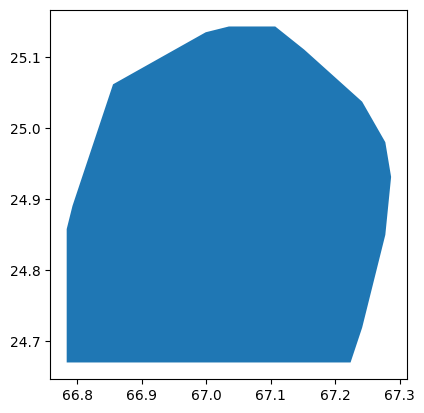

In [74]:
from osrmareas import areas
karachi_ll = [24.910871, 67.030846]
karachi_df = areas.get_routes(karachi_ll, radius_km=30, grid_km_size=1)
karachi_df_shp = areas.get_ameba(karachi_df, max_km = 30)
karachi_df_shp.plot()

<!--  -->
### Cropping the Raster

In this section, we'll demonstrate how to crop a raster file using a shapefile representing the market area.

In [75]:
raster_path = (
    "../data/8_night_light/pk_night_light_harm.tiff"  # Path to the raster file
)
shapefile = karachi_df_shp  # Shapefile representing the market area


# Define a function to extract features compatible with rasterio
def getFeatures(gdf: gpd.GeoDataFrame):
    import json

    return [json.loads(gdf.to_json())["features"][0]["geometry"]]


# Crop the raster file using the shapefile
with rio.open(raster_path) as src:
    out_image, out_transform = mask(src, getFeatures(shapefile), crop=True)
values = out_image.flatten()
rows, cols = np.indices(out_image.shape[-2:])
x, y = rio.transform.xy(out_transform, rows.flatten(), cols.flatten())

# Create a DataFrame with values and coordinates
data = {"x": x, "y": y, "z": values}
df = pd.DataFrame(data)
df

,x,y,z
0,66.783332,25.141667,-3.400000e+38
1,66.791666,25.141667,-3.400000e+38
2,66.799999,25.141667,-3.400000e+38
3,66.808332,25.141667,-3.400000e+38
4,66.816666,25.141667,-3.400000e+38
...,...,...,...
3533,67.249999,24.666667,-3.400000e+38
3534,67.258332,24.666667,-3.400000e+38
3535,67.266666,24.666667,-3.400000e+38
3536,67.274999,24.666667,-3.400000e+38


### Filtering Observations within the Shapefile

Next, we'll filter the observations that fall within the boundaries of the shapefile.

In [76]:
points_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["x"], df["y"])).set_crs(
    epsg=4326
)
points_inside = gpd.sjoin(points_df, shapefile, how="inner", op="within")
points_inside

,x,y,z,geometry,index_right
30,67.033332,25.141667,7.000000e+00,POINT (67.03333 25.14167),0
31,67.041666,25.141667,7.000000e+00,POINT (67.04167 25.14167),0
32,67.049999,25.141667,7.000000e+00,POINT (67.05000 25.14167),0
33,67.058332,25.141667,7.000000e+00,POINT (67.05833 25.14167),0
34,67.066666,25.141667,7.000000e+00,POINT (67.06667 25.14167),0
...,...,...,...,...,...
3465,67.191666,24.675000,-3.400000e+38,POINT (67.19167 24.67500),0
3466,67.199999,24.675000,-3.400000e+38,POINT (67.20000 24.67500),0
3467,67.208332,24.675000,-3.400000e+38,POINT (67.20833 24.67500),0
3468,67.216666,24.675000,-3.400000e+38,POINT (67.21667 24.67500),0


Visualize to verify correspondence with the cropped shapefile.

<Axes: >

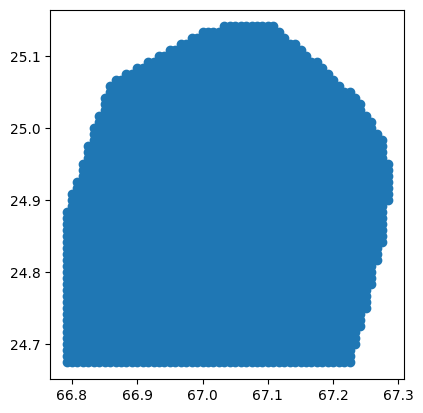

In [77]:
points_inside.plot()

### Metrics

For this case, we'll compute metrics including mean, standard deviation, and sum.

In [78]:
import numpy as np

target_name = "nightlight"

# Define the metrics
metrics = [np.mean, np.std, np.sum]
points_result = points_inside.dropna(subset=["z"])
stats = points_result["z"].agg(metrics).values.flatten()

# Assign computed metrics to the shapefile
(
    shapefile[f"{target_name}_mean"],
    shapefile[f"{target_name}_sd"],
    shapefile[f"{target_name}_sum"],
) = stats
shapefile

,geometry,nightlight_mean,nightlight_sd,nightlight_sum
0,"POLYGON ((66.78381 24.67029, 66.78381 24.85790...",-inf,inf,-inf


<!--  -->



<!--  -->
### Join All in a Function

To ensure reusability, let's encapsulate the previous procedure into a function that ultimately returns a DataFrame containing the geometry of the shapefile along with its metrics.

In [79]:
def metric_result(
    centroid_from,
    path_raster: str,
    radius_km=4,
    grid_km=1,
    target_name="metrics",
    metrics=[np.mean, np.std, np.sum],
):
    # Generate a shapefile
    routes = areas.get_routes(centroid_from, radius_km=radius_km, grid_km_size=grid_km)
    shapefile = areas.get_ameba(routes, max_km=radius_km)

    # Crop the raster
    with rio.open(path_raster) as src:
        out_image, out_transform = mask(src, getFeatures(shapefile), crop=True)

    values = out_image.flatten()
    rows, cols = np.indices(out_image.shape[-2:])
    x, y = rio.transform.xy(out_transform, rows.flatten(), cols.flatten())

    data = {"x": x, "y": y, "z": values}
    df = pd.DataFrame(data)

    # Points inside
    points_df = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df["x"], df["y"])
    ).set_crs(epsg=4326)
    points_inside = gpd.sjoin(points_df, shapefile, how="inner", op="within")

    # Generate Metrics
    points_result = points_inside.dropna(subset=["z"])
    stats = points_result["z"].agg(metrics).values.flatten()

    (
        shapefile[f"{target_name}_mean"],
        shapefile[f"{target_name}_sd"],
        shapefile[f"{target_name}_sum"],
    ) = stats

    return shapefile

Now, let's test it with other coordinates.

In [80]:
centroides_pk = [
    [24.951004, 66.985305],
    [24.910871, 67.030846],
    [24.958856, 67.040013],
    [24.933989, 67.107785],
]

metric_df = gpd.GeoDataFrame()
for centroid in centroides_pk:
    result = metric_result(centroid, path_raster=raster_path)
    metric_df = pd.concat((metric_df, result))

100%|██████████| 64/64 [00:00<00:00, 126.74it/s]


<Axes: >

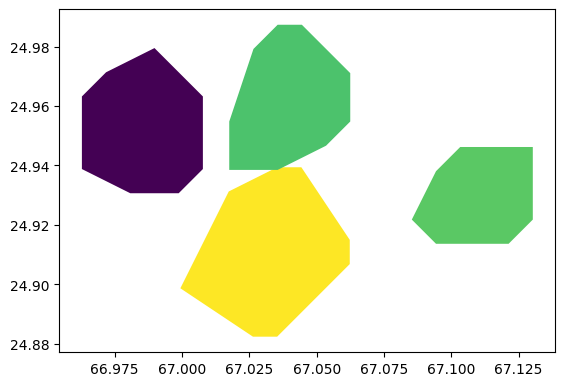

In [81]:
metric_df.plot(column='metrics_mean')

In conclusion, to obtain metrics, you need the centroid coordinates, the path to the raster file, the radius of the raster file, the grid width explained in the first part, and lastly, a prefix name for the columns to facilitate merging multiple databases.
<!--  -->



<!--  -->
## Other Metrics

To streamline the process mentioned earlier, we can use a function that takes the aforementioned parameters as inputs.

In [82]:
def metric_df_calculate(centroids, raster_path, **kwargs):
    metric_df = gpd.GeoDataFrame()
    for centroid in centroids:
        result = metric_result(centroid, raster_path, **kwargs)
        metric_df = pd.concat((metric_df, result))
    return metric_df

### Nightlight

#### Harm 

Nightlight data can provide insights into urbanization and economic activity. Let's calculate metrics for the "Harm" version of nightlight data.

In [83]:
r_path = "../data/8_night_light/pk_night_light_harm.tiff"
name_col = "nightlight_harm"
metric_df_calculate(centroides_pk, raster_path=r_path, target_name=name_col)

100%|██████████| 64/64 [00:00<00:00, 132.73it/s]


,geometry,nightlight_harm_mean,nightlight_harm_sd,nightlight_harm_sum
0,"POLYGON ((66.98081 24.93064, 66.96285 24.93879...",62.538460,0.706018,1626.0
0,"POLYGON ((67.02635 24.88235, 66.99940 24.89865...",63.000000,0.000000,2079.0
0,"POLYGON ((67.01756 24.93849, 67.01756 24.95478...",62.869564,0.344350,1446.0
0,"POLYGON ((67.09431 24.91362, 67.08533 24.92177...",62.882355,0.332106,1069.0


#### Original

Now, let's compute metrics for the original nightlight data.

In [84]:
r_path = '../data/8_night_light/pk_night_light.tiff'
name_col = "nightlight"
metric_df_calculate(centroides_pk, raster_path = r_path, target_name=name_col)

100%|██████████| 64/64 [00:00<00:00, 131.30it/s]


,geometry,nightlight_mean,nightlight_sd,nightlight_sum
0,"POLYGON ((66.98081 24.93064, 66.96285 24.93879...",37.389423,9.111515,3551.995361
0,"POLYGON ((67.02635 24.88235, 66.99940 24.89865...",45.842979,8.936888,6051.273438
0,"POLYGON ((67.01756 24.93849, 67.01756 24.95478...",41.734932,13.678473,3714.408936
0,"POLYGON ((67.09431 24.91362, 67.08533 24.92177...",33.580753,8.758814,2451.395020


### Population

Population density is a crucial indicator for various analyses. Let's calculate metrics based on population data.

In [85]:
pop_tif = "../data/1_density/pak_ppp_2018_1km_Aggregated.tif"
name_col = "population"
metric_df_calculate(centroides_pk, pop_tif, target_name=name_col)

100%|██████████| 64/64 [00:00<00:00, 112.17it/s]


,geometry,population_mean,population_sd,population_sum
0,"POLYGON ((66.98081 24.93064, 66.96285 24.93879...",8332.324219,1757.787231,1.916435e+05
0,"POLYGON ((67.02635 24.88235, 66.99940 24.89865...",40848.847656,11281.851562,1.348012e+06
0,"POLYGON ((67.01756 24.93849, 67.01756 24.95478...",29824.935547,15117.108398,7.754483e+05
0,"POLYGON ((67.09431 24.91362, 67.08533 24.92177...",20428.244141,8269.201172,3.881366e+05


### Motor

Friction surfaces, such as motorized friction, can indicate the ease of travel. Let's analyze motorized friction data.

In [86]:
motor_tif = "../data/5_friction_surface/2020_motorized_friction_surface.geotiff"
motor_name = "motor"
metric_df_calculate(centroides_pk, motor_tif, target_name=motor_name)

100%|██████████| 64/64 [00:00<00:00, 123.04it/s]


,geometry,motor_mean,motor_sd,motor_sum
0,"POLYGON ((66.98081 24.93064, 66.96285 24.93879...",0.00093,0.000196,0.0214
0,"POLYGON ((67.02635 24.88235, 66.99940 24.89865...",0.00080,0.000217,0.0264
0,"POLYGON ((67.01756 24.93849, 67.01756 24.95478...",0.00110,0.000227,0.0231
0,"POLYGON ((67.09431 24.91362, 67.08533 24.92177...",0.00092,0.000154,0.0184


### Altitude

Altitude data provides valuable insights into terrain characteristics. Let's compute altitude metrics.

In [87]:
srtm_tif = "../data/6_srtm/PK_srtm.tif"
name_col = "altitude"
metric_df_calculate(centroides_pk, srtm_tif, target_name=name_col)

100%|██████████| 64/64 [00:00<00:00, 126.16it/s]


,geometry,altitude_mean,altitude_sd,altitude_sum
0,"POLYGON ((66.98081 24.93064, 66.96285 24.93879...",64.127129,11.175416,161921.0
0,"POLYGON ((67.02635 24.88235, 66.99940 24.89865...",25.073862,6.582567,83170.0
0,"POLYGON ((67.01756 24.93849, 67.01756 24.95478...",63.665825,15.961967,151461.0
0,"POLYGON ((67.09431 24.91362, 67.08533 24.92177...",44.649883,7.974960,77155.0


These functions allow for efficient computation of various metrics, providing valuable information for spatial analysis and decision-making.
<!--  -->